<img src="../../img/emergent_filter_evaluation.png" alt="Outlier Detection with Emergent Filters" style="width: 100%; border-radius: 20px;"/>

## Objective


## Scope


## Limitation


## Output data

In [ ]:
import sys
sys.path.append('../')

from utils.data_preparation import *
from utils.utils import *
from utils.utils_filter import *
from utils.lookup_table_creation import *

import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from matplotlib import pyplot as plt
import math

# <p style="background-color:#4A3228;color:white;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following datasets are required:
- Train / Validata Dataset: *[master_train_land_cover.csv / master_validata_land_cover.csv](https://drive.google.com/file/d/1FFky4GRfgNUkkpGPac7XBWtj5LahVOoe/view?usp=drive_link)*
- Shapefile of 50x50km EEA grids of Europe: *[eea_50_km_ref-grid-europe/inspire_compatible_grid_50km.shp](https://drive.google.com/drive/folders/1atS5eomHYxX-q_5b8WGqFVDtqP3-d8qP)*
- Name translator file that translates species names into ornitho species names: *[translation_species_names_de_vs_ch.csv](https://drive.google.com/drive/folders/1VN87gPc_XA212rpyaq2xpJcOSDu8hN5v)*

Please edit the paths below to match your environment.

In [2]:
date_format = '%d.%m.%Y'  # ch

path_translator_names = r'D:\\Simon\\Documents\\GP\\data\\util_files\\translator_files\\translation_species_names_de_vs_ch.csv' 
path_eea_grids = r'D:\\Simon\\Documents\\GP\\data\\util_files\\eea_grid_files\\eea_europe_grids_50km\\inspire_compatible_grid_50km.shp'

train_path = r'D:\\Simon\\Documents\\GP\\data\\datasets\\validata\\master_train_land_cover.csv'  
validata_path = r'D:\\Simon\\Documents\\GP\\data\\datasets\\validata\\master_validata_land_cover.csv'  

In [3]:
validata = pd.read_csv(validata_path, delimiter=get_delimiter(validata_path), low_memory=False)
validata = standardize_data(validata, path_translator_species_names=path_translator_names)

# <p style="background-color:#4A3228;color:white;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣ Load data </p>

For this notebook, a standardized dataset of bird sightings from Switzerland and Germany, covering the period from 2018 to 2022, is used. It already contains the self-generated features *eea_grid_id*, *altitude*, and *land_use* (this is master_train_land_cover.csv).

Additionally, the validation dataset provided by ornitho.ch is used for evaluation, comprising both correct and manually falsified data points from 2023 (this is master_validata_land_cover.csv).

After loading the data, it is split into test and train data for further usage.
The date is converted from a standard format (day-month-year) to the day of the year (1-365) for better compatibility.

In [4]:
X_train = pd.read_csv(train_path, index_col=0, low_memory=False)
X_test = pd.read_csv(validata_path, index_col=0, low_memory=False)
y_test = X_test['edited']
y_test_per_species = X_test[['name_species', 'edited']]
X_test = X_test.drop(columns=['edited'])

In [5]:
X_train.date = pd.to_datetime(X_train.date).dt.dayofyear
X_test.date = pd.to_datetime(X_test.date).dt.dayofyear

In [6]:
X_train.head()

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,...,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent
0,29666972,8,Haubentaucher,1,53.157760,8.676993,-1,0,0,de,...,0.0,0.008314,0.0,0.0,0.0,0.0,0.0,0.0,0.496190,0.0
1,29654244,397,Schwarzkehlchen,1,53.127639,8.957263,1,2,0,de,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,29654521,463,Wiesenpieper,1,50.850941,12.146953,269,2,0,de,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,29666414,8,Haubentaucher,1,51.076006,11.038316,157,8,0,de,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.747651,0.0
4,29656211,8,Haubentaucher,1,51.389380,7.067282,52,10,0,de,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.343413,0.0


# <p style="background-color:#4A3228;color:white;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Emergent Filter Lookup creation </p>

In this chapter, three lookup tables are created and used for emergent filters. Each filter has its own approach to make sure a threshold value can be set and adjusted to fit the user's needs.
First the Grid / Year filter is implemented which incoperates only the grid and the year and how likely a bird is to be in it. The second filter is the land cover filter which consists of percentages of how likely a bird is in a given environment. Lastly the altitude filter is implemented, which depends on altitude ranges and the probability of a bird to be spotted in that range.
The functions (to generate the lookup tables) are also accessible via *utils.lookup_table_creation.py* but are explained in detail below.

## Grid / Year lookup creation
This lookup table, originally developed by Marina Siebold in the "02_modeling/01_Emergent_Filters" directory, has been reimported in the current context for a comparative analysis with filters associated with land cover and altitude. 

This is the detailed description provided by Marina Siebold from *01_Emergent_Filters.ipynb*:

>Emergent Filters calculate the relative proportions of bird sightings for each species in the past year. From this, they derive the probability of a bird sighting for each species, grid, and date in the following year. This process results in probability curves throughout the year for sighting a particular bird species within a specific grid.

>eBird computes a metric that reflects the frequency of species reporting. This metric is obtained by dividing the number of checklists reporting a specific species by the total number of checklists submitted for a particular region. The outcome provides an indication of the 'probability' of encountering a particular bird species within that specific region. Since each observation includes information about the bird's location and time of detection, it becomes feasible to calculate the occurrence frequencies of bird species at various spatial scales and for any given date [1].

>We implement this concept through a multi-step process.

>Initially, we generate a dataframe encompassing all potential combinations of bird species, EEA grids, and dates. This step is aimed to calculate the likelihood of a sighting for all possible combinations.

>Subsequently, for each combination, the total number of all submitted sightings on that specific day and grid is determined.

>Then, the count of all submitted sightings of the corresponding bird species on that day and grid is added.

>Finally, we calculate the likelihood or frequency of bird sightings, following the methodology employed by eBird. This is expressed as: $$frequency = \frac{n\_sightings}{total\_sightings}$$

>Additionally, eBird introduces one more step:
>"To account for [...] [the] variation in the number of checklists per day, the frequencies were calculated based on a sliding 7-day window. The frequency for day X was calculated using a total number of checklists from 3 days prior through 3 days after day X. We then assigned the highest initial frequency within that same sliding 7- day window to day X. The resulting frequency is an estimate of the likelihood of observing a species on each of the 365 days of the year." [1]

>Thus, we determine the rolling max frequency using a centered sliding 7-day window based on the prior calculated frequency. 

>Due to the relatively smaller dataset available from ornitho.de and ornitho.ch compared to eBird, the plausibility values can exhibit considerable fluctuations even with the 7-day window due to the limited number of sightings. To address this issue, as the only adjustment to the eBird methodology, we intoduce an additional centered rolling window. This window averages values over a 30-day period, with the intent of mitigating fluctuations and achieving a smoother representation of the data.

>By utilizing the calculated plausibility values, the sightings can now be assigned a plausibility rating ranging from 0 to 100%.

The finished lookup table then contains all the species combined with each grid, each day of the year and the probability for each combination.

In [7]:
def circular_rolling(group):
    df = group.copy()
    df = pd.concat([df.iloc[-19:], df, df.iloc[:17]])
    df['frequency_rolling'] = df.frequency.rolling(window=7, center=True).max()
    df['plausibility'] = df.frequency_rolling.rolling(window=30, center=True).mean()
    return df.iloc[19:].iloc[:-17]

def create_grid_year_lookup(bird_sightings:pd.DataFrame, on_year: int):
    """
    Create a lookup table for a given year and available grids.
    :param df: Dataframe.
    :param on_year: Year on which to calculate emergent filters.
    :return: Emergent Filters.
    """
    bird_sightings = bird_sightings[bird_sightings.date.str.contains(str(on_year))]
    bird_sightings['day_of_year'] = pd.to_datetime(bird_sightings.date).dt.dayofyear
    bird_sightings = bird_sightings[['name_species', 'eea_grid_id', 'day_of_year']]

    grid_list = bird_sightings.eea_grid_id.unique()
    day_list = range(1, 366)
    species_list = bird_sightings.name_species.unique()

    all_combinations = pd.MultiIndex.from_product([species_list, grid_list, day_list], names=['name_species', 'eea_grid_id', 'day_of_year'])
    all_combinations = pd.DataFrame(index=all_combinations).reset_index()

    by_days = bird_sightings.groupby(['day_of_year', 'eea_grid_id']).count().reset_index()
    by_days.rename(columns={'name_species':'total_sightings'}, inplace=True)
    by_days = all_combinations.merge(by_days, on=['eea_grid_id', 'day_of_year'], how='left')
    by_days['total_sightings'] = by_days['total_sightings'].fillna(0).astype(int)
    
    by_days_and_species = bird_sightings.groupby(['name_species', 'day_of_year', 'eea_grid_id']).size().reset_index()
    by_days_and_species.rename(columns={0:'n_sightings'}, inplace=True)

    total_df = by_days.merge(by_days_and_species, on=['name_species', 'eea_grid_id', 'day_of_year'], how='left')
    total_df['n_sightings'] = total_df['n_sightings'].fillna(0).astype(int)
    total_df['frequency'] = total_df.n_sightings / total_df.total_sightings
    total_df['frequency'] = total_df['frequency'].fillna(0)

    groups = total_df.groupby(['name_species', 'eea_grid_id'])
    result_df = pd.concat([circular_rolling(group) for _, group in groups])
    result_df.reset_index(drop=True, inplace=True)
    result_df.drop(columns=['total_sightings', 'n_sightings', 'frequency', 'frequency_rolling'], inplace=True)

    grid_year_lookup = result_df.groupby(['name_species', 'eea_grid_id', 'day_of_year'])['plausibility'].first().to_dict()
    return grid_year_lookup

In [8]:
emergent_filters_grid_year = create_grid_year_lookup(validata, 2023)

In [9]:
emergent_filters_grid_year

{('Alpenschneehuhn', '50kmE4000N2550', 1): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 2): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 3): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 4): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 5): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 6): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 7): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 8): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 9): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 10): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 11): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 12): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 13): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 14): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 15): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 16): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 17): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 18): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 19): 0.0,
 ('Alpenschneehuhn', '50kmE4000N2550', 20): 0.0,
 ('Alpenschneehuhn', '50kmE40

## Land Cover Lookup creation
Next up is the Land Cover Lookup creation. 
The function *create_land_cover_lookup* is designed to generate a lookup table that provides the mean percentages of different land cover types associated with bird sightings for each species. This process facilitates the analysis of habitat preferences for various bird species based on their observed locations.

Explanation of the Process

1. Land Cover Columns Identification:
The function begins by defining a list of columns that represent the percentage of different land cover types. These columns include various land types such as urban areas, agricultural lands, forests, wetlands, and others. These percentages reflect the composition of the environment where bird sightings have been recorded.

2. Grouping and Mean Calculation:
The function groups the bird sightings data by the species name (name_species). For each species, the mean percentage of each land cover type is calculated. This step is crucial for summarizing the typical habitat preferences of each species across all recorded sightings.

3. Column Renaming:
After calculating the mean percentages, the function renames the columns to reflect that they contain mean values. For example, urban_area_percent is renamed to mean_urban_area_percent. This renaming clarifies that the values in the resulting lookup table represent average percentages.

4. Return Statement:
The function returns the landcover_lookup dataframe, which contains the species names along with the mean land cover percentages for each land cover type. This table can then be used for further analysis, such as identifying the preferred habitats of different bird species.

In summary, this function efficiently processes bird sighting data to produce a detailed lookup table that reflects the average environmental characteristics associated with each bird species.

In [13]:
def create_land_cover_lookup(bird_sightings: pd.DataFrame):
    """
    Create a lookup table for land cover percentages.
    
    :param bird_sightings: DataFrame with bird sightings.
    :param land_cover_columns: List of columns representing land cover percentages.
    :return: Lookup table with mean percentages for each land cover type per species.
    """
    land_cover_columns = [
        "urban_area_percent","industrial_area_percent","agriculture_area_percent","forest_area_percent","grassland_area_percent",
        "shrubland_area_percent","coastal_area_percent","rocky_area_percent","sparsley_vegetated_area_percent","burnt_area_percent","glacier_area_percent",
        "wetlands_area_percent","water_area_percent","unclassified_area_percent"
    ]
    landcover_lookup = bird_sightings.groupby('name_species')[land_cover_columns].mean().reset_index()
    landcover_lookup.columns = ['name_species'] + [f'mean_{col}' for col in land_cover_columns]
    return landcover_lookup

In [14]:
land_cover_lookup = create_land_cover_lookup(validata)

In [15]:
land_cover_lookup.head()

,name_species,mean_urban_area_percent,mean_industrial_area_percent,mean_agriculture_area_percent,mean_forest_area_percent,mean_grassland_area_percent,mean_shrubland_area_percent,mean_coastal_area_percent,mean_rocky_area_percent,mean_sparsley_vegetated_area_percent,mean_burnt_area_percent,mean_glacier_area_percent,mean_wetlands_area_percent,mean_water_area_percent,mean_unclassified_area_percent
0,Alpenschneehuhn,0.005668,0.000000,0.041882,0.105420,0.383932,0.024181,0.003818,0.203855,0.223305,6.018450e-04,0.002003,0.001595,0.003738,0.0
1,Auerhuhn,0.010778,0.000000,0.061637,0.743151,0.079032,0.085276,0.000000,0.005594,0.009261,0.000000e+00,0.000649,0.001025,0.003596,0.0
2,Bergente,0.070914,0.009135,0.191517,0.038221,0.024248,0.004123,0.000265,0.000220,0.001006,0.000000e+00,0.000000,0.083777,0.576575,0.0
3,Berghänfling,0.050572,0.003065,0.306686,0.010138,0.099951,0.002328,0.013483,0.000000,0.000000,0.000000e+00,0.000000,0.393960,0.119818,0.0
4,Bergpieper,0.054976,0.003705,0.395798,0.097533,0.197319,0.012557,0.001501,0.024465,0.039747,9.266602e-07,0.001151,0.057917,0.113329,0.0


## Altitude Lookup creation

The provided function *create_altitude_lookup* implements a process to assign altitude bins to bird sightings and subsequently create a lookup table that summarizes the probability of encountering each bird species within specific altitude ranges.

Explanation of the Process

1. Altitude Bin Assignment (assign_altitude_bins function):

    - Bin Creation:
    The assign_altitude_bins function first creates a series of altitude bins (segments) based on the specified range (bin_range). The range is defined by a start value, a stop value, and a step size, which determines the width of each bin.

    - Labeling Bins:
    Labels for these bins are generated, indicating the altitude range each bin covers (e.g., 0-100 meters, 100-200 meters, etc.).

    - Bin Assignment:
    The function then assigns each bird sighting to one of these altitude bins based on the altitude value in the sighting record. This assignment adds a new column, altitude_bin, to the dataframe, which categorizes the sightings according to their altitude ranges.

2. Altitude Lookup Table Creation (create_altitude_lookup function):

    - Bin Assignment:
    The create_altitude_lookup function begins by invoking the assign_altitude_bins function to categorize each bird sighting into altitude bins.

    - Counting Sightings per Bin:
    The function groups the data by species and altitude bin, calculating the number of sightings (n_sightings) within each bin for every species.

    - Calculating Total Sightings per Species:
    It then calculates the total number of sightings for each species across all altitude bins.

    - Probability Calculation:
    By merging these two datasets, the function computes the probability of encountering each species within a specific altitude range. This probability is calculated as the number of sightings within a bin divided by the total number of sightings for that species.

    - Pivoting the Data:
    The resulting data is pivoted to create a matrix where each row represents a bird species, each column represents an altitude bin, and the cell values represent the probability of observing the species within that bin.

    - Final Lookup Table:
    The final lookup table is returned as a dataframe, providing a species-specific view of altitude preferences.

This process allows for the effective analysis of bird species' altitude preferences by providing a probabilistic view of their sightings across different altitude ranges.

In [56]:
def assign_altitude_bins(df: pd.DataFrame, bin_size: int =100):
    """
    Assign altitude bins to each sighting based on specified bin size.
    
    :param df: DataFrame with bird sightings including an 'altitude' column.
    :param bin_size: The size of each altitude bin.
    :return: DataFrame with an additional 'altitude_bin' column.
    """
    min_altitude = df['altitude'].min().astype(int)
    max_altitude = df['altitude'].max().astype(int)
    
    bins = np.arange(min_altitude + 1, max_altitude + 1 + bin_size, bin_size)
    df['altitude_bin'] = pd.cut(df['altitude'], bins=bins, include_lowest=True, precision=0)
    return df

def create_altitude_lookup(bird_sightings: pd.DataFrame, bin_size: int = 50, min_sightings: int = 10, smoothing: float = 1.0):
    """
    Create a lookup table for altitude ranges with smoothed probabilities.
    
    :param bird_sightings: DataFrame with bird sightings.
    :param bin_size: The size of each altitude bin.
    :param min_sightings: Minimum number of sightings required for reliable probability estimation.
    :param smoothing: Smoothing factor to avoid zero probabilities (Laplace smoothing).
    :return: DataFrame representing the altitude lookup table.
    """
    bird_sightings = assign_altitude_bins(bird_sightings, bin_size=bin_size)
   
    sightings_per_bin = bird_sightings.groupby(['name_species', 'altitude_bin']).size().reset_index(name='n_sightings')
    
    total_sightings_per_species = bird_sightings.groupby('name_species').size().reset_index(name='total_sightings')

    sightings_per_bin = sightings_per_bin.merge(total_sightings_per_species, on='name_species')
    sightings_per_bin['smoothed_n_sightings'] = sightings_per_bin['n_sightings'] + smoothing
    sightings_per_bin['smoothed_total'] = sightings_per_bin['total_sightings'] + (smoothing * sightings_per_bin['altitude_bin'].nunique())
    sightings_per_bin['probability'] = sightings_per_bin['smoothed_n_sightings'] / sightings_per_bin['smoothed_total']
    sightings_per_bin = sightings_per_bin[sightings_per_bin['total_sightings'] >= min_sightings]
    
    altitude_lookup = sightings_per_bin.pivot_table(
        index='name_species',
        columns='altitude_bin',
        values='probability',
        fill_value=smoothing / (sightings_per_bin['total_sightings'] + (smoothing * sightings_per_bin['altitude_bin'].nunique()))
    ).reset_index()
    
    return altitude_lookup


In [57]:
altitude_lookup = create_altitude_lookup(validata)

In [58]:
altitude_lookup

altitude_bin,name_species,"(-48, 3]","(3, 53]","(53, 103]","(103, 153]","(153, 203]","(203, 253]","(253, 303]","(303, 353]","(353, 403]",...,"(4053, 4103]","(4103, 4153]","(4153, 4203]","(4203, 4253]","(4253, 4303]","(4303, 4353]","(4353, 4403]","(4403, 4453]","(4453, 4503]","(4503, 4553]"
0,Alpenschneehuhn,0.000994,0.000994,0.000994,0.000994,0.000994,0.000994,0.000994,0.000994,0.001988,...,0.000994,0.000994,0.000994,0.000994,0.000994,0.000994,0.000994,0.000994,0.000994,0.000994
1,Auerhuhn,0.001134,0.001134,0.003401,0.099773,0.003401,0.001134,0.001134,0.001134,0.001134,...,0.001134,0.001134,0.001134,0.001134,0.001134,0.001134,0.001134,0.001134,0.001134,0.001134
2,Bergente,0.352516,0.145762,0.066161,0.033770,0.024121,0.005169,0.001378,0.001723,0.136458,...,0.000345,0.000345,0.000345,0.000345,0.000345,0.000345,0.000345,0.000345,0.000345,0.000345
3,Berghänfling,0.734714,0.127219,0.030572,0.009862,0.008876,0.000986,0.003945,0.000986,0.000986,...,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986
4,Bergpieper,0.029500,0.044764,0.056865,0.048244,0.050538,0.025071,0.020405,0.022619,0.076163,...,0.000158,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079
5,Braunkehlchen,0.112236,0.224809,0.077275,0.043701,0.035381,0.020800,0.027271,0.029708,0.063703,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000084,0.000042
6,Dreizehenspecht,0.000807,0.000807,0.000807,0.000807,0.000807,0.000807,0.000807,0.000807,0.001614,...,0.000807,0.000807,0.000807,0.000807,0.000807,0.000807,0.000807,0.000807,0.000807,0.000807
7,Flussuferläufer,0.229797,0.162195,0.106540,0.095001,0.053168,0.030009,0.030824,0.030824,0.079589,...,0.000041,0.000041,0.000041,0.000041,0.000041,0.000082,0.000041,0.000041,0.000041,0.000041
8,Gelbspötter,0.157703,0.379757,0.157175,0.070692,0.038055,0.012619,0.012553,0.014403,0.037923,...,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066
9,Gänsegeier,0.000759,0.006074,0.003797,0.003037,0.001519,0.003037,0.003037,0.003797,0.008352,...,0.001519,0.000759,0.000759,0.000759,0.001519,0.000759,0.000759,0.000759,0.000759,0.001519


# <p style="background-color:#4A3228;color:white;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣ Emergent Filters evaluation</p>

## Scoring Calcualtions
#### Accuracy
Accuracy measures the proportion of correctly predicted instances (both true positives and true negatives) out of the total number of instances.
This metric gives an overall indication of how often the model is correct. However, it can be misleading in cases of imbalanced datasets.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$



#### Precision
Precision measures the proportion of true positive predictions out of all positive predictions (true positives + false positives).
Precision is especially useful when the cost of false positives is high, as it indicates how reliable a positive prediction is.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$



#### Recall (Sensitivity, True Positive Rate)
Recall (also known as Sensitivity) measures the proportion of true positive predictions out of all actual positives (true positives + false negatives).
Recall is important in situations where missing a positive instance (i.e., false negative) is more critical.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$



#### F1 Score
The F1 Score is the harmonic mean of Precision and Recall. It provides a balance between the two metrics, particularly useful when you want to find a balance between Precision and Recall.
The F1 Score is especially useful when dealing with imbalanced datasets where Precision and Recall might differ significantly.

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$



#### Specificity (True Negative Rate)
Specificity measures the proportion of true negative predictions out of all actual negatives (true negatives + false positives).
Specificity is crucial when the cost of false positives is high, indicating how well the model identifies negative instances correctly.

$$
\text{Specificity} = \frac{TN}{TN + FP}
$$

## Grid / Year evaluation

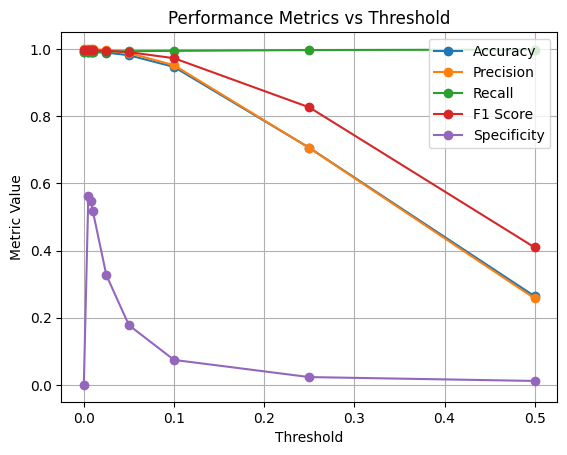

In [10]:
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Specificity': []
}
thresholds = [0.00001, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

for threshold in thresholds:
    conf_mat = evaluate_emergent_filters_grid_year(X_test, y_test, emergent_filters_grid_year, threshold=threshold)
    TP, FP = conf_mat[0, 0], conf_mat[0, 1]
    FN, TN = conf_mat[1, 0], conf_mat[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1_score)
    metrics['Specificity'].append(specificity)

for metric in metrics:
    plt.plot(thresholds, metrics[metric], marker='o', label=metric)

plt.title('Performance Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
conf_mats = []
thresholds = [0.005, 0.01]
for threshold in thresholds:
    conf_mat = evaluate_emergent_filters_grid_year(X_test, y_test, emergent_filters_grid_year, threshold=threshold)
    conf_mats.append(conf_mat)

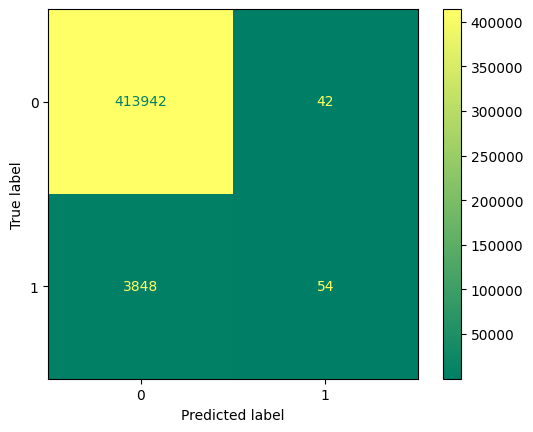

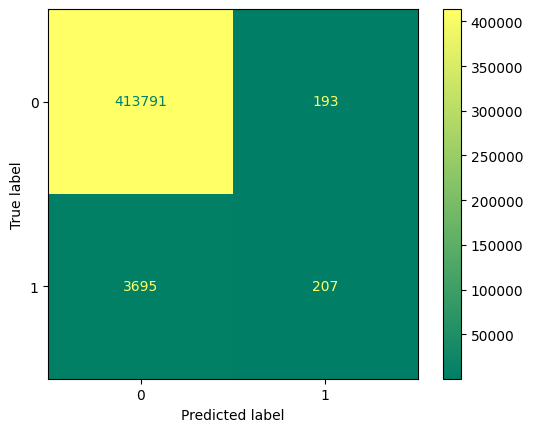

In [12]:
for conf_mat in conf_mats:
    ConfusionMatrixDisplay(conf_mat).plot(cmap='summer');

## Land cover evaluation

### Outlier Detection
A threshold is applied to the Euclidean distance to identify outliers. If the distance exceeds this threshold, the sighting is flagged as an outlier, suggesting it occurred in an atypical environment for that species.

### Evaluation of the Land Cover Filter

To assess the filter's performance, various thresholds are tested. Key performance metrics such as Accuracy, Precision, Recall, F1 Score, and Specificity are calculated for each threshold. These metrics help evaluate the filter's effectiveness in distinguishing between typical and atypical bird sightings based on land cover data.

The evaluation results are plotted, allowing for visualization of how each metric varies with the threshold. This analysis aids in identifying the optimal threshold that balances correctly identifying true positives (typical sightings) while minimizing false positives (incorrectly flagged outliers).

Additionally, confusion matrices are generated for selected thresholds, providing a detailed view of the filter's performance across different sensitivity levels. These matrices offer insights into the true positives, false positives, true negatives, and false negatives, deepening the understanding of the filter's behavior under various conditions.

In [16]:
def euclidean_distance(list1, list2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(list1, list2)))

def is_outlier(row, land_cover_dict, threshold):
    """
    Determine if a bird sighting is an outlier based on land cover data using Euclidean distance.
    
    :param row: Series with land cover percentages for a sighting.
    :param land_cover_dict: Dictionary with mean land cover percentages per species.
    :param threshold: Threshold for determining outlier status.
    :return: 1 if outlier, 0 if not an outlier.
    """
    species = row['name_species']
    
    land_covers = land_cover_dict[species]
    observed_values = [row[f'{col[5:]}'] for col in land_covers]
    mean_values = [land_covers[col] for col in land_covers]
    
    distance = euclidean_distance(observed_values, mean_values)
    
    return 1 if distance > threshold else 0

def evaluate_emergent_filters_landcover(X_test: pd.DataFrame, y_test: pd.Series, land_cover_lookup: pd.DataFrame, threshold: float = 0.1):
    """
    Evaluate if bird sightings are outliers based on land cover data using a lookup table and Euclidean distance.
    
    :param X_test: DataFrame with test bird sightings data.
    :param y_test: Series with binary labels (0 for plausible, 1 for outlier).
    :param land_cover_lookup: DataFrame with mean land cover percentages per species.
    :param threshold: Threshold for outlier detection based on Euclidean distance.
    :return: Confusion matrix comparing true labels (y_test) and predicted labels (y_pred).
    """
    land_cover_dict = land_cover_lookup.set_index('name_species').to_dict('index')

    y_pred = X_test.apply(is_outlier, axis=1, land_cover_dict=land_cover_dict, threshold=threshold)
    
    return confusion_matrix(y_test, y_pred)


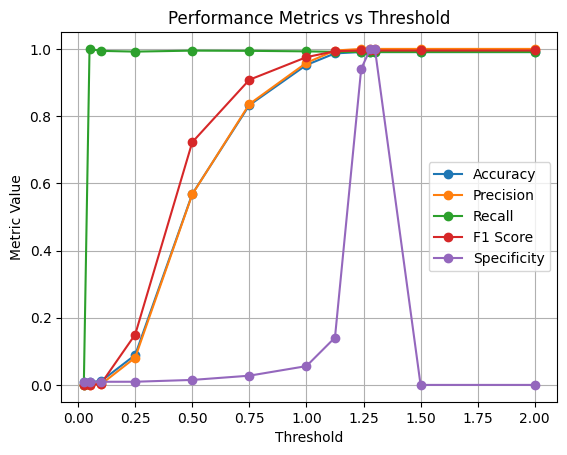

In [17]:
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Specificity': []
}
thresholds = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.125, 1.24, 1.28, 1.3, 1.5, 2]

for threshold in thresholds:
    conf_mat = evaluate_emergent_filters_landcover(X_test, y_test, land_cover_lookup, threshold=threshold)
    TP, FP = conf_mat[0, 0], conf_mat[0, 1]
    FN, TN = conf_mat[1, 0], conf_mat[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1_score)
    metrics['Specificity'].append(specificity)

for metric in metrics:
    plt.plot(thresholds, metrics[metric], marker='o', label=metric)

plt.title('Performance Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
conf_mats = []
thresholds = [1.28]
for threshold in thresholds:
    conf_mat = evaluate_emergent_filters_landcover(X_test, y_test, land_cover_lookup, threshold)
    conf_mats.append(conf_mat)

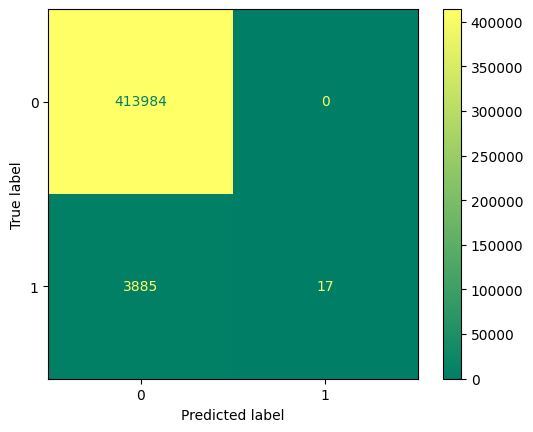

In [49]:
for conf_mat in conf_mats:
    ConfusionMatrixDisplay(conf_mat).plot(cmap='summer')

## Altitude evaluation

In [40]:
def is_altitude_plausible(row, altitude_lookup, threshold=0.05):
    """
    Determine if a bird sighting is plausible based on altitude data.
    
    :param row: A single record (Series) representing a bird sighting with 'name_species' and 'altitude'.
    :param altitude_lookup: DataFrame containing altitude probabilities per species.
    :param threshold: Probability threshold below which a sighting is considered implausible.
    :return: 1 if implausible, 0 if plausible.
    """
    species = row['name_species']
    altitude = row['altitude']
    
    species_data = altitude_lookup[altitude_lookup['name_species'] == species]
    
    if species_data.empty:
        return 1
    
    bins = species_data.columns[1:]
    bin_edges = [interval.left for interval in bins] + [bins[-1].right]
    altitude_bin = pd.IntervalIndex.from_arrays(bin_edges[:-1], bin_edges[1:]).get_indexer([altitude])[0]
    
    if altitude_bin == -1:
        return 1
    
    probability = species_data.iloc[0, altitude_bin + 1]
    return int(probability < threshold)

def evaluate_emergent_filters_altitude(X_test: pd.DataFrame, y_test: pd.Series, altitude_lookup: pd.DataFrame, threshold: float = 0.05):
    """
    Evaluate the altitude filter on a test dataset.
    
    :param X_test: DataFrame with test bird sightings data including 'name_species' and 'altitude'.
    :param y_test: Series with binary labels (0 for plausible, 1 for implausible).
    :param altitude_lookup: DataFrame containing altitude probabilities per species.
    :param threshold: Probability threshold below which a sighting is considered implausible.
    :return: Confusion matrix comparing true labels (y_test) and predicted labels (y_pred).
    """
    y_pred = X_test.apply(is_altitude_plausible, axis=1, altitude_lookup=altitude_lookup, threshold=threshold)
    return confusion_matrix(y_test, y_pred)

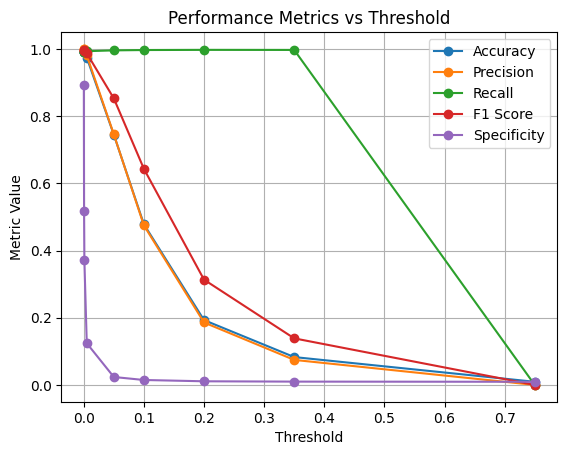

In [41]:
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Specificity': []
}
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.05, 0.1, 0.2, 0.35, 0.75]

for threshold in thresholds:
    conf_mat = evaluate_emergent_filters_altitude(X_test, y_test, altitude_lookup, threshold=threshold)
    TP, FP = conf_mat[0, 0], conf_mat[0, 1]
    FN, TN = conf_mat[1, 0], conf_mat[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1_score)
    metrics['Specificity'].append(specificity)

for metric in metrics:
    plt.plot(thresholds, metrics[metric], marker='o', label=metric)

plt.title('Performance Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()
# with bins = 50

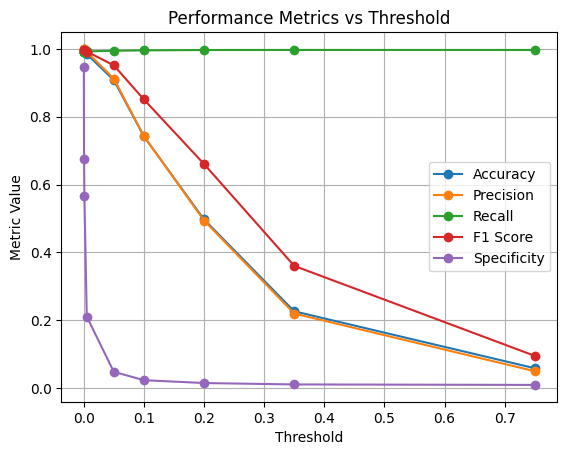

In [35]:
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Specificity': []
}
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.05, 0.1, 0.2, 0.35, 0.75]

for threshold in thresholds:
    conf_mat = evaluate_emergent_filters_altitude(X_test, y_test, altitude_lookup, threshold=threshold)
    TP, FP = conf_mat[0, 0], conf_mat[0, 1]
    FN, TN = conf_mat[1, 0], conf_mat[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1_score)
    metrics['Specificity'].append(specificity)

for metric in metrics:
    plt.plot(thresholds, metrics[metric], marker='o', label=metric)

plt.title('Performance Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()
# with bins = 100

In [36]:
conf_mats = []
thresholds = [0.0001]
for threshold in thresholds:
    conf_mat = evaluate_emergent_filters_altitude(X_test, y_test, altitude_lookup, threshold=threshold)
    conf_mats.append(conf_mat)

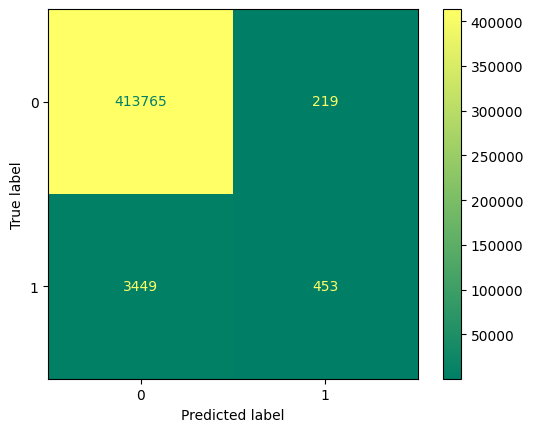

In [33]:
for conf_mat in conf_mats:
    ConfusionMatrixDisplay(conf_mat).plot(cmap='summer')

# <p style="background-color:#4A3228;color:white;border-radius:10px 10px 10px 10px;"> &nbsp;5️⃣ Initial Assessment: Possible Opportunities and Limitations </p>

# References
[1] Yu, Jun, et al. "Automated data verification in a large-scale citizen science project: a case study." 2012 IEEE 8th International Conference on E-Science. IEEE, 2012.